In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set()

palette = {
    "conventional": "tab:blue",
    "conditional": "tab:orange",
    "hybrid": "tab:green",
    "projection": "tab:red"
}

df = pd.read_csv("data/data.csv")
df.head()

,top_n,rank,true_value,params,ppf025,ppf975,sim_no,estimator,data_file
0,1,0,0.045,0.131315,-1.004121,0.579467,0,conditional,movers
1,2,0,0.045,0.222837,-0.569538,0.595267,0,conditional,movers
2,2,1,0.024,-0.356603,-3.452920,0.504527,0,conditional,movers
3,3,0,0.045,0.254296,-0.422476,0.600630,0,conditional,movers
4,3,1,0.024,-0.090065,-1.978997,0.541278,0,conditional,movers


In [2]:
df["pr_overestimate"] = (df.params > df.true_value)
df["coverage"] = (df.ppf025 < df.true_value) & (df.true_value < df.ppf975)
df["len_ci"] = df.ppf975 - df.ppf025

In [25]:
def make_blank_figure(ax, blank_ax=None):
    if blank_ax is None:
        fig, blank_ax = plt.subplots()
    blank_ax.set_xlim(ax.get_xlim())
    blank_ax.set_xticklabels(ax.get_xticklabels())
    blank_ax.set_xticks(ax.get_xticks())
    blank_ax.set_xlabel(ax.get_xlabel())
    blank_ax.set_ylim(ax.get_ylim())
    blank_ax.set_yticklabels(ax.get_yticklabels())
    blank_ax.set_yticks(ax.get_yticks())
    blank_ax.set_title(ax.get_title())
    blank_ax.set_ylabel(ax.get_ylabel())
    return blank_ax

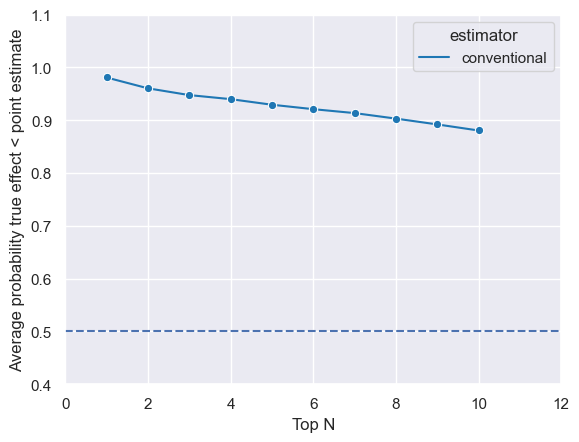

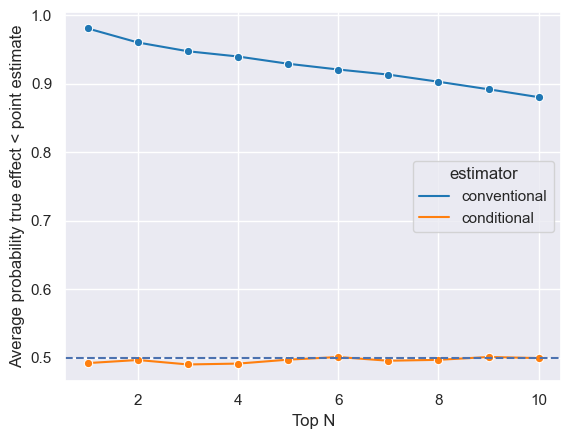

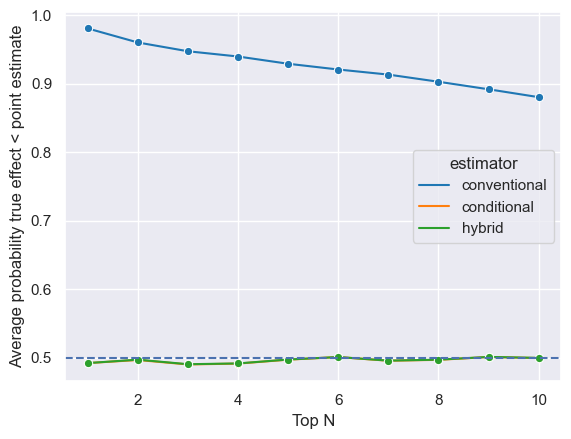

<ipython-input-6-3ef4a5aa013b>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  blank_ax.set_xticklabels(ax.get_xticklabels())
<ipython-input-6-3ef4a5aa013b>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  blank_ax.set_yticklabels(ax.get_yticklabels())


In [8]:
def make_pr_bias_graph(estimators):
    ax = sns.lineplot(
        data=df[df.estimator.isin(estimators)],
        x="top_n",
        y="pr_overestimate",
        hue="estimator",
        hue_order=estimators,
        palette=palette,
        ci=None,
        marker="o"
    )
    ax.axhline(.5, linestyle="--")
    ax.set_ylabel("Average probability true effect < point estimate")
    ax.set_xlabel("Top N")
    plt.savefig(f"plots/pr_overestimate_{estimators}.png", bbox_inches="tight")
    plt.show()
    return ax

estimators = []
for estimator in ("conventional", "conditional", "hybrid"):
    estimators.append(estimator)
    ax = make_pr_bias_graph(estimators)
blank_ax = make_blank_figure(ax)
plt.savefig("plots/pr_overestimate_blank.png", bbox_inches="tight")
blank_ax.axhline(.5, linestyle="--")
plt.savefig("plots/pr_overestimate_line.png", bbox_inches="tight")

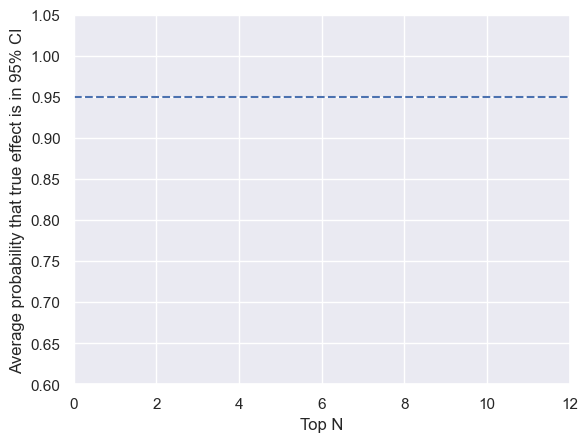

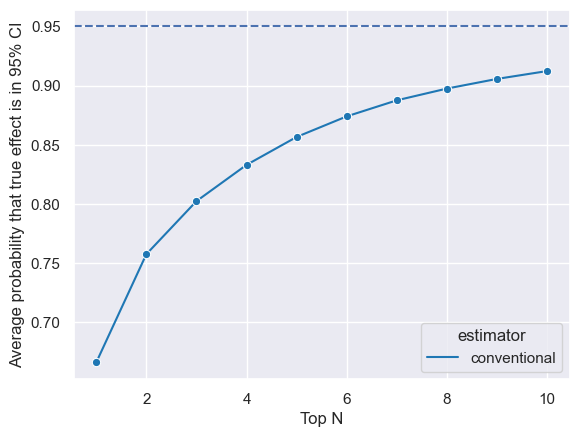

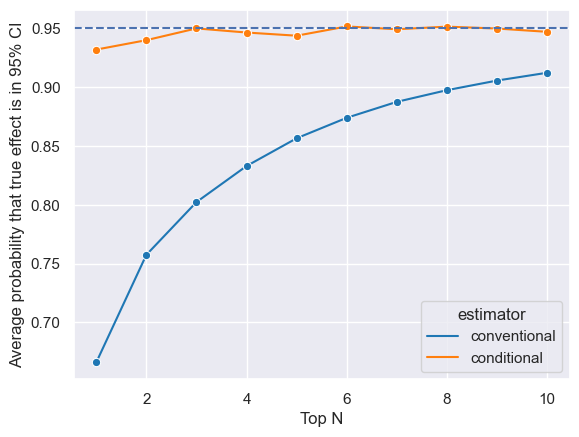

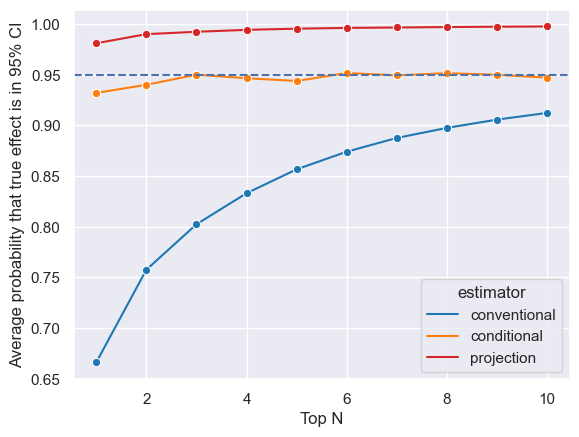

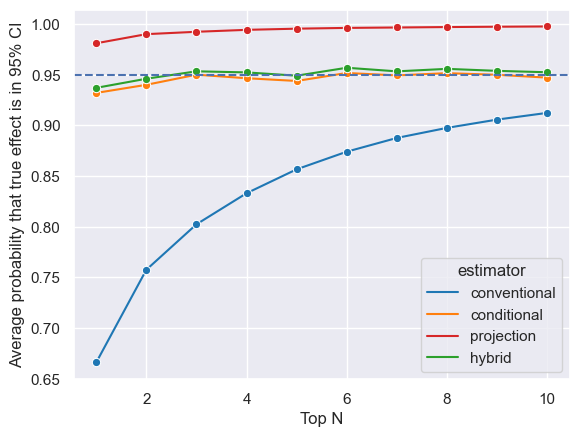

<ipython-input-6-3ef4a5aa013b>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  blank_ax.set_xticklabels(ax.get_xticklabels())
<ipython-input-6-3ef4a5aa013b>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  blank_ax.set_yticklabels(ax.get_yticklabels())


In [10]:
def make_coverage_plot(estimators):
    fig, ax = plt.subplots()
    sns.lineplot(
        data=df[df.estimator.isin(estimators)],
        x="top_n",
        y="coverage",
        hue="estimator",
        hue_order=estimators,
        palette=palette,
        ci=None,
        marker="o",
        ax=ax
    )
    ax.axhline(.95, linestyle="--")
    ax.set_ylabel("Average probability that true effect is in 95% CI")
    ax.set_xlabel("Top N")
    plt.savefig(f"plots/coverage{estimators}.png")
    plt.show()
    return ax

estimators = []
for estimator in ("conventional", "conditional", "projection", "hybrid"):
    estimators.append(estimator)
    ax = make_coverage_plot(estimators)
blank_ax = make_blank_figure(ax)
plt.savefig("plots/coverage_blank.png")
blank_ax.axhline(.95, linestyle="--")
plt.savefig("plots/coverage_line.png")

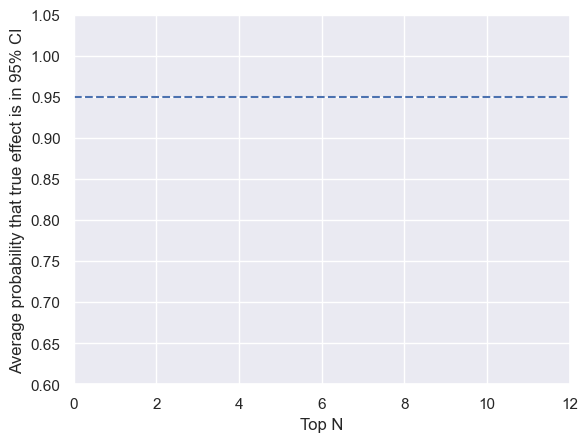

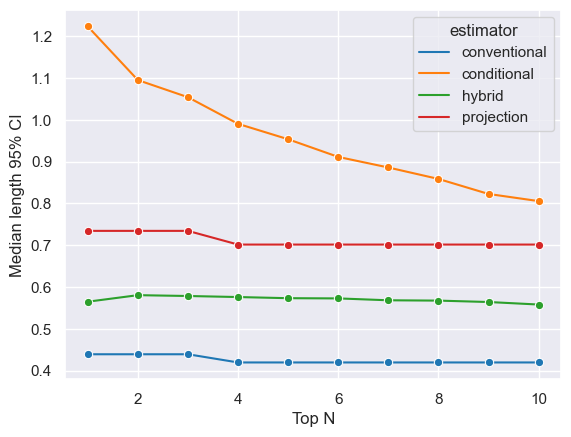

<ipython-input-6-3ef4a5aa013b>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  blank_ax.set_xticklabels(ax.get_xticklabels())
<ipython-input-6-3ef4a5aa013b>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  blank_ax.set_yticklabels(ax.get_yticklabels())


In [11]:
fig, ax = plt.subplots()
sns.lineplot(
    data=df,
    x="top_n",
    y="len_ci",
    hue="estimator",
    hue_order=["conventional", "conditional", "hybrid", "projection"],
    palette=palette,
    ci=None,
    marker="o",
    estimator=lambda x: np.quantile(x, .5),
    ax=ax
)
ax.set_ylabel("Median length 95% CI")
ax.set_xlabel("Top N")
plt.savefig("plots/len_ci.png")
plt.show()

ax = make_blank_figure(ax)
plt.savefig("plots/len_ci_blank.png")

In [12]:
import matplotlib.pyplot as plt

from conditional_inference.bayes.classic import LinearClassicBayes
from conditional_inference.rqu import RQU

DATA_FILE = "../losers-empirical/movers.csv"
TOP_N = 3

results = {}

conventional_model = LinearClassicBayes.from_csv(DATA_FILE, prior_cov=np.inf)
argsort = np.argsort(-conventional_model.mean)
cols = argsort[:TOP_N]
col_names = np.array(conventional_model.exog_names)[cols]
results["conventional"] = conventional_model.fit(cols=cols)

rqu_model = RQU.from_csv(DATA_FILE)
results["conditional"] = rqu_model.fit(cols=cols, rank=np.arange(TOP_N))
results["hybrid"] = rqu_model.fit(cols=cols, rank=np.arange(TOP_N), beta=.005)
results["projection"] = rqu_model.fit(cols=cols, projection=True)

estimates = {}
for key, result in results.items():
    estimates[key] = {
        "conf_int": result.conf_int(),
        "params": result.params
    }

c:\users\dbspe\repos\conditional-inference\src\conditional_inference\stats.py:165: RuntimeWarning: divide by zero encountered in double_scalars
  x_init = (norm.pdf(a) - norm.pdf(b)) / ((norm.cdf(b) - norm.cdf(a)))
c:\users\dbspe\repos\conditional-inference\src\conditional_inference\stats.py:145: RuntimeWarning: divide by zero encountered in double_scalars
  + (norm.pdf(b, mu) - norm.pdf(a, mu))
C:\Users\DBSpe\anaconda3\envs\conditional-inference\lib\site-packages\scipy\optimize\_numdiff.py:556: RuntimeWarning: invalid value encountered in double_scalars
  dx = x[i] - x0[i]  # Recompute dx as exactly representable number.
C:\Users\DBSpe\anaconda3\envs\conditional-inference\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
c:\users\dbspe\repos\conditional-inference\src\conditional_inference\stats.py:137: RuntimeWarning: invalid value encountered in double_scalars
  return -x * mu + (0.5 * mu ** 2 + np.log(norm.cdf(

<ipython-input-25-44637e4d9894>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  blank_ax.set_xticklabels(ax.get_xticklabels())
<ipython-input-25-44637e4d9894>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  blank_ax.set_yticklabels(ax.get_yticklabels())


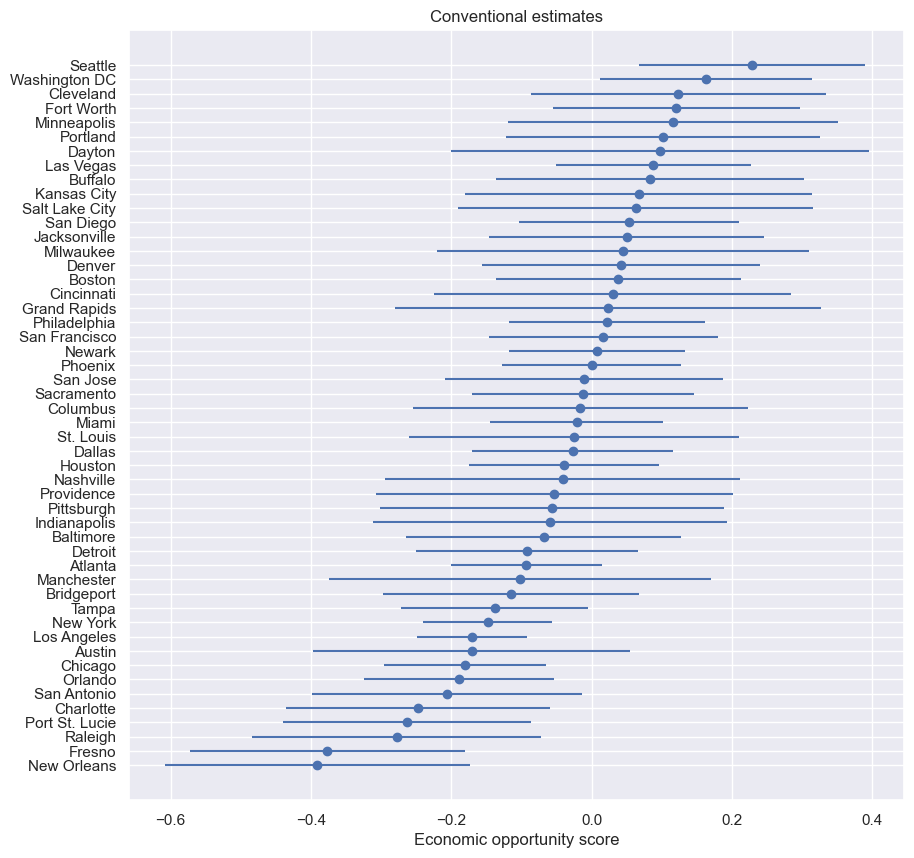

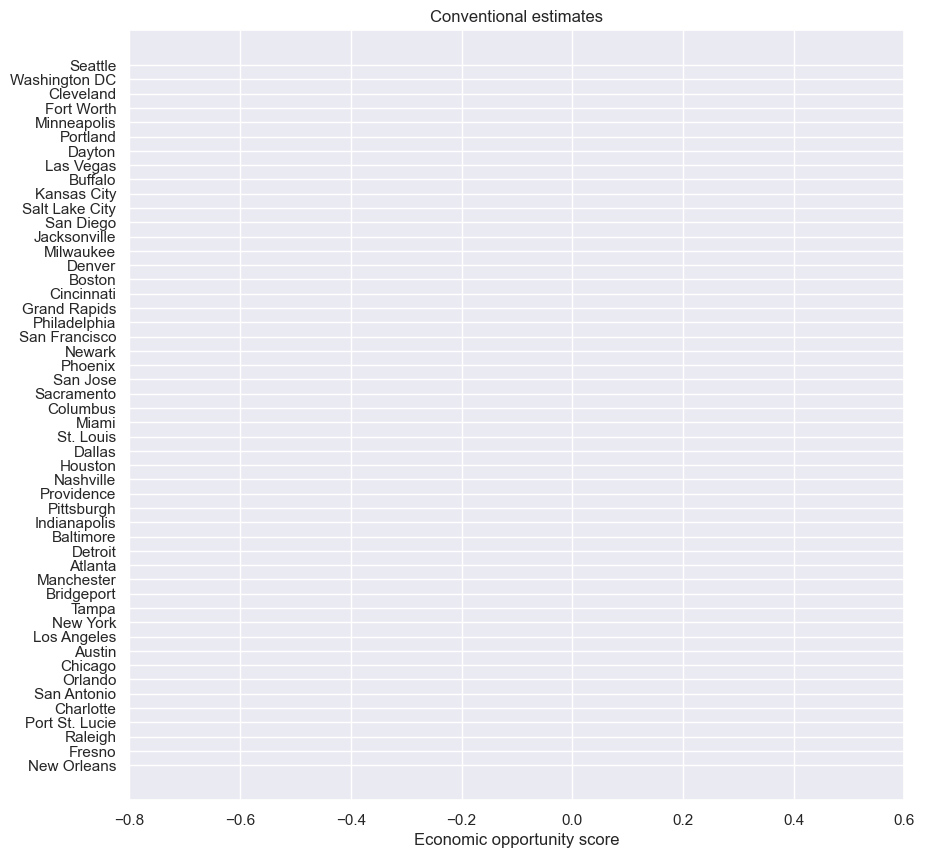

In [26]:
fig, ax = plt.subplots(figsize=(10, 10))
conventional_model.fit(cols="sorted").point_plot(title="Conventional estimates", yname="Economic opportunity score", ax=ax)
plt.savefig("plots/original_estimates.png", bbox_inches="tight")
fig, blank_ax = plt.subplots(figsize=(10, 10))
ax = make_blank_figure(ax, blank_ax)
plt.savefig("plots/original_estimates_blank.png", bbox_inches="tight")
plt.show()

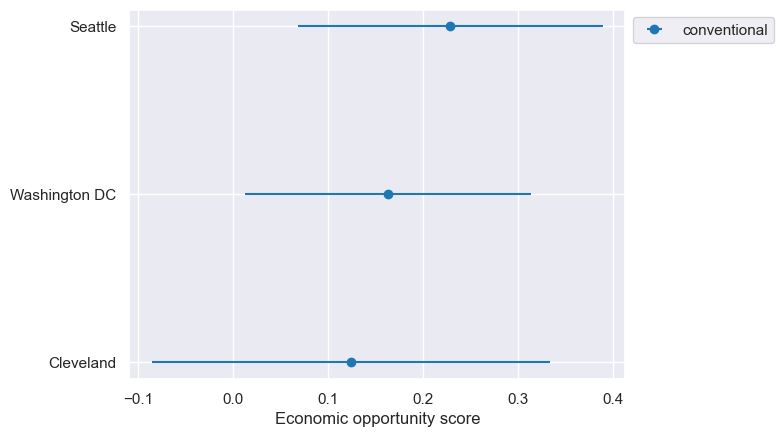

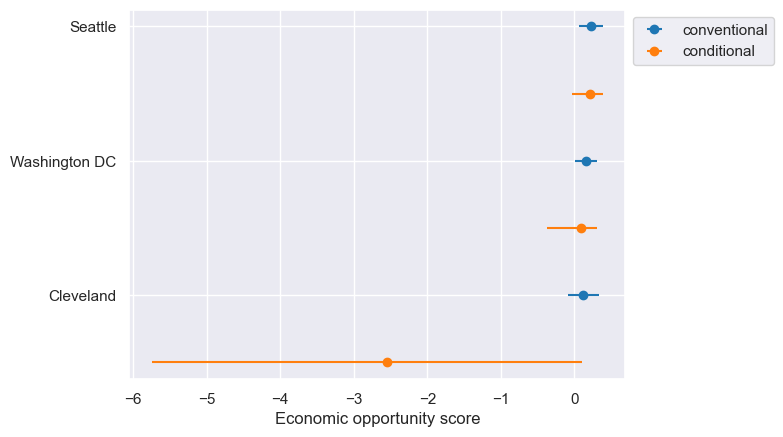

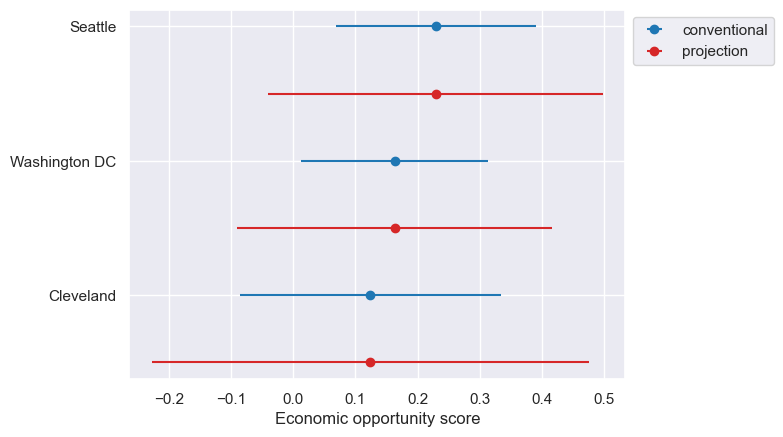

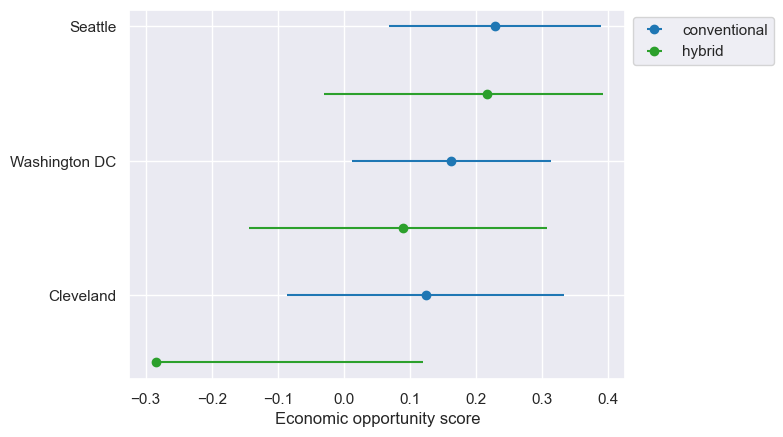

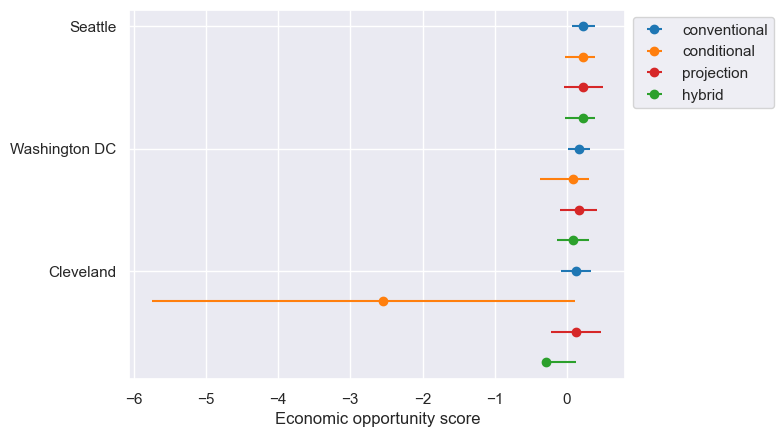

In [21]:
def make_point_plot(keys):
    _, ax = plt.subplots()
    for i, key in enumerate(keys):
        params = estimates[key]["params"]
        conf_int = estimates[key]["conf_int"]
        ax.errorbar(
            x=params,
            y=np.arange(TOP_N, 0, -1) - i / len(keys),
            xerr=[params - conf_int[:, 0], conf_int[:, 1] - params],
            fmt="o",
            label=key,
            color=palette[key]
        )
    ax.set_xlabel("Economic opportunity score")
    ax.set_yticks(np.arange(TOP_N, 0, -1))
    ax.set_yticklabels(col_names)
    plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
    plt.savefig(f"plots/estimates_{keys}.png", bbox_inches="tight")
    plt.show()

estimators_set = (
    ("conventional",),
    ("conventional", "conditional"),
    ("conventional", "projection"),
    ("conventional", "hybrid"),
    ("conventional", "conditional", "projection", "hybrid")
)
for keys in estimators_set:
    make_point_plot(keys)